### 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 불필요한 경고를 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 3.1 MNIST

In [2]:
from sklearn.datasets import fetch_openml

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


그림 저장: some_digit_plot


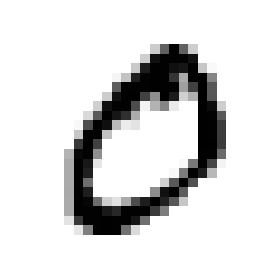

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]    # 맨 첫번째 샘플
some_digit_image = some_digit.reshape(28, 28)    # 특성을 28x28배열로 크기를 바꿈

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [5]:
# 실제 X[0]의 숫자는?
y[0]

0

레이블의 타입은 주로 문자열이다. y를 정수로 변환한다.

In [6]:
y = y.astype(np.uint8)

MNIST는 이미 훈련 세트와 테스트 세트를 나누어 놓았다. (앞쪽 60,000개가 훈련 세트이고 뒤쪽 10,000개가 테스트 세트이다.)  
훈련 세트는 이미 섞여있기하나의 fold에 0부터 9까지의 모든 숫자가 포함되어 있다.
그러니 다시 섞을 필요가 없다.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

0인 숫자와 0이 아닌 숫자로 분류해보자.

In [8]:
# train과 test에서 레이블이(= y값이) '5'인 것들만 따로 정의
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

In [9]:
# 확률적 경사 하강법(=SGD) 분류기 사용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# 예측
sgd_clf.predict([some_digit])
# 결과는 True로 맞게 예측하였다.

array([ True])

# 3.3 성능 측정
회귀 모델보다 성능 지표가 훨씬 많다.

## 3.3.1 교차 검증을 사용한 정확도 측정

일단 StratifiedKFold로 폴드를 나눈다. 클래스별 비율이 유지되도록 폴드를 만들어준다.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(sgd_clf)
    # train
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_0[train_index]
    # test
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_0[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)    # 확률 예측
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9905
0.97925
0.98255


cross_val_score()함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier모델을 평가해본다.

In [14]:
from sklearn.model_selection import cross_val_score

# cv=3이니까 fold개수는 3개임
# scoring="accuracy"이니까 '정확도'에 대한(= 정확한 예측의 비율에 대한) 값이 나올 것임
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.98015, 0.95615, 0.9706 ])

모든 교차 검증 폴드(= 총 3개의 검증 폴드)에서 정확도가 95% 이상이다.

이제는 모든 이미지를 '0 아님'클래스로 분류하는 더미분류기를 만들어 비교해보자.

In [18]:
from sklearn.base import BaseEstimator

class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_0_clf = Never0Classifier()
cross_val_score(never_0_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.70385, 1.     , 1.     ])

실제 이미지의 10%정도만 '숫자 0'이기 때문에 알고리즘은 찍어도 '숫자 0 아님'클래스로 분류할 수 있다.  
**정확도는 분류기의 성능 측정 지표로 선호되지 않는다.**  
특히 **불균형한 데이터셋**을 다룰때 더욱 그렇다.

## 3.3.2 오차 행렬